In [95]:
# Spark libs
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.window import Window
import pyspark.sql.functions as func
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark import SQLContext
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Others
import pandas as pd
import numpy as np
import datetime
import time

# Graphs libs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_dt

In [96]:
OBV_i = True
CCI_i = True
RSI_i = True
MACD_i = True
ManualSplit = False
Date_Convert = False

DEBUG = True

DT = False
RT = False
GBT = True


RANDOM_SEED = 12345

In [97]:
def RSI(dataframe, window_length, avg_type, column='Close'):
    data = dataframe.toPandas()
    # Get just the close
    close = data['Close']
    # Get the difference in price from previous step
    delta = close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous
    # row to calculate the differences
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    if avg_type == "EWMA":
        roll_up = up.ewm(span=window_length, min_periods=window_length).mean()
        roll_down = down.abs().ewm(
            span=window_length, min_periods=window_length).mean()
    elif avg_type == "SMA":
        roll_up = pd.rolling_mean(up, window_length)
        roll_down = pd.rolling_mean(down.abs(), window_length)
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    RSI = pd.DataFrame({'RSI': RSI})
    data = data.join(RSI)
    result_df = spark.createDataFrame(data)
    return result_df

In [98]:
# Spark context simple configuration
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

#Path to file with CSV
path_to_csv = "./Datasets/Orlen.csv"

fresh_df = spark.read.csv(path_to_csv, header=True, inferSchema=True)

temporary_df = fresh_df.select(
    fresh_df["Date"].cast("Date"), fresh_df["Open"].cast("float"),
    fresh_df["High"].cast("float"), fresh_df["Volume"].cast("int"),
    fresh_df["Low"].cast("float"), fresh_df["Close"].cast("float"))

df_cleared = temporary_df.filter(temporary_df.Open.isNotNull())

if DEBUG:
    df_cleared.show()

# Creating new column with shifted Close price by 1 day
df_lag = df_cleared.withColumn('prev_day_price',
                               func.lag(df_cleared['Close']).over(
                                   Window.orderBy("Date")))

# Daily return calculation
df_daily_return = df_lag.withColumn(
    'Daily return', (df_lag['Close'] - df_lag['prev_day_price']))

# Profit label calculation
# 1 if stock risen up, 0 is it went down
df_profit = df_daily_return.withColumn(
    'Profit', (F.when(df_daily_return["Daily return"] < 0, 0).otherwise(1)))

df_shifted_profit = df_profit.withColumn(
    'Profit',
    func.lag(df_profit['Profit'], count=-1).over(Window.orderBy("Date")))

final_df = df_shifted_profit.filter(
    df_shifted_profit["Daily return"].isNotNull())

final_df = final_df.drop("prev_day_price").withColumnRenamed(
    existing="Daily return", new="Daily return")

# Removing redudant columns
final_df = final_df.drop("Daily return")
final_df = final_df.drop("prev_day_price")

final_df = final_df.select("*").withColumn("id", monotonically_increasing_id())

if DEBUG:
    final_df.show()

#Conversion to desired typesf
converted_df = final_df

+----------+-----+-----+------+-----+-----+
|      Date| Open| High|Volume|  Low|Close|
+----------+-----+-----+------+-----+-----+
|2012-05-25|7.706|7.706|     0|7.706|7.706|
|2012-05-29|7.802|7.809|     0|7.802|7.809|
|2012-05-30| 7.95| 7.95|    10|7.782|7.782|
|2012-05-31|7.688|7.688|     0|7.688|7.688|
|2012-06-01|7.526|7.526|   300|7.459|7.459|
|2012-06-04|7.328|7.328|     0|7.328|7.328|
|2012-06-05|7.514|7.514|     0|7.514|7.514|
|2012-06-06|7.317|7.317|     0|7.317|7.317|
|2012-06-08|7.502|7.569|     0|7.502|7.569|
|2012-06-11|7.701|7.701|     0|7.701|7.701|
|2012-06-12|7.671|7.671|     0|7.671|7.671|
|2012-06-13|7.935|7.935|     0|7.935|7.935|
|2012-06-14|7.978|7.978|     0|7.978|7.978|
|2012-06-15|8.089|8.089|     0|8.089|8.089|
|2012-06-18|8.337|8.337|     0|8.337|8.337|
|2012-06-19|8.223|8.223|     0|8.223|8.223|
|2012-06-20|8.587|8.824|   370|8.587|8.824|
|2012-06-21|8.634|8.634|   350|8.616|8.616|
|2012-06-22|8.404|8.457|  1250|8.404|8.441|
|2012-06-25|8.402|8.402|     0|8

In [99]:
# Commodity Channel Index
def CCI(spark_df, ndays):
    data = spark_df.toPandas()
    TP = (data['High'] + data['Low'] + data['Close']) / 3
    CCI = pd.Series(
        (TP - pd.rolling_mean(TP, ndays)) /
        (0.015 * pd.rolling_std(TP, ndays)),
        name='CCI')
    data = data.join(CCI)
    result_df = spark.createDataFrame(data)
    return result_df

In [100]:
# Moving average convergence divergence
def MACD(dataframe, nfast=12, nslow=24, column='Close'):
    data = dataframe.toPandas()
    # Get just the close
    price = data[column]
    # Get the difference in price from previous step
    emaslow = pd.ewma(price, span=nslow, min_periods=1)
    emafast = pd.ewma(price, span=nfast, min_periods=1)
    #     MACD = pd.DataFrame({'MACD': emafast-emaslow, 'emaSlw': emaslow, 'emaFst': emafast})
    MACD = pd.DataFrame({'MACD': emafast - emaslow})
    data = data.join(MACD)
    result_df = spark.createDataFrame(data)
    return result_df

In [101]:
#Columns without Date
# converted_df = converted_df.select(
#     [col(c).cast('float') for c in converted_df.columns if c. not in {'Date'}])
# Date column!
df_date = converted_df.select(converted_df.Date)

#Convert date to splitted format
if Date_Convert:
    split_col = pyspark.sql.functions.split(converted_df['Date'], '-')
    converted_df = converted_df.withColumn('Year',
                                           split_col.getItem(0).cast('int'))
    converted_df = converted_df.withColumn('Month',
                                           split_col.getItem(1).cast('int'))
    converted_df = converted_df.withColumn('Day',
                                           split_col.getItem(2).cast('int'))
    if DEBUG:
        converted_df.show()

converted_df = converted_df.drop("Date")

In [102]:
if MACD_i:
    converted_df = MACD(converted_df)
    converted_df = converted_df.select(
        [col(c).cast('float') for c in converted_df.columns])
    if DEBUG:
        converted_df.show()

+-----+-----+------+-----+-----+------+----+-------------+
| Open| High|Volume|  Low|Close|Profit|  id|         MACD|
+-----+-----+------+-----+-----+------+----+-------------+
|7.802|7.809|   0.0|7.802|7.809|   0.0| 0.0|          0.0|
| 7.95| 7.95|  10.0|7.782|7.782|   0.0| 1.0|  -5.62499E-4|
|7.688|7.688|   0.0|7.688|7.688|   0.0| 2.0|-0.0034248475|
|7.526|7.526| 300.0|7.459|7.459|   0.0| 3.0| -0.012326616|
|7.328|7.328|   0.0|7.328|7.328|   1.0| 4.0| -0.021733696|
|7.514|7.514|   0.0|7.514|7.514|   0.0| 5.0| -0.019541662|
|7.317|7.317|   0.0|7.317|7.317|   1.0| 6.0|  -0.02610725|
|7.502|7.569|   0.0|7.502|7.569|   1.0| 7.0| -0.018885486|
|7.701|7.701|   0.0|7.701|7.701|   0.0| 8.0|-0.0074942946|
|7.671|7.671|   0.0|7.671|7.671|   1.0| 9.0| -7.705355E-4|
|7.935|7.935|   0.0|7.935|7.935|   1.0|10.0|  0.017208392|
|7.978|7.978|   0.0|7.978|7.978|   1.0|11.0|   0.03229937|
|8.089|8.089|   0.0|8.089|8.089|   1.0|12.0|  0.048852794|
|8.337|8.337|   0.0|8.337|8.337|   0.0|13.0|   0.0739499

/home/zapo/Documents/Spark/spark/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=24,min_periods=1,adjust=True,ignore_na=False).mean()
  import sys
/home/zapo/Documents/Spark/spark/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=1,adjust=True,ignore_na=False).mean()
  


In [103]:
if CCI_i:
    converted_df = CCI(converted_df, 14)
    converted_df = converted_df.select(
        [col(c).cast('float') for c in converted_df.columns])
    if DEBUG:
        converted_df.show()

+-----+-----+------+-----+-----+------+----+-------------+---------+
| Open| High|Volume|  Low|Close|Profit|  id|         MACD|      CCI|
+-----+-----+------+-----+-----+------+----+-------------+---------+
|7.802|7.809|   0.0|7.802|7.809|   0.0| 0.0|          0.0|      NaN|
| 7.95| 7.95|  10.0|7.782|7.782|   0.0| 1.0|  -5.62499E-4|      NaN|
|7.688|7.688|   0.0|7.688|7.688|   0.0| 2.0|-0.0034248475|      NaN|
|7.526|7.526| 300.0|7.459|7.459|   0.0| 3.0| -0.012326616|      NaN|
|7.328|7.328|   0.0|7.328|7.328|   1.0| 4.0| -0.021733696|      NaN|
|7.514|7.514|   0.0|7.514|7.514|   0.0| 5.0| -0.019541662|      NaN|
|7.317|7.317|   0.0|7.317|7.317|   1.0| 6.0|  -0.02610725|      NaN|
|7.502|7.569|   0.0|7.502|7.569|   1.0| 7.0| -0.018885486|      NaN|
|7.701|7.701|   0.0|7.701|7.701|   0.0| 8.0|-0.0074942946|      NaN|
|7.671|7.671|   0.0|7.671|7.671|   1.0| 9.0| -7.705355E-4|      NaN|
|7.935|7.935|   0.0|7.935|7.935|   1.0|10.0|  0.017208392|      NaN|
|7.978|7.978|   0.0|7.978|7.978|  

/home/zapo/Documents/Spark/spark/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  
/home/zapo/Documents/Spark/spark/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  import sys


In [104]:
# OBV indicator calculation
if OBV_i:
    temp_df = converted_df.toPandas()
    df_obv = spark.createDataFrame(
        temp_df.assign(OBV=(temp_df.Volume * (
            ~temp_df.Close.diff().le(0) * 2 - 1)).cumsum()))
    converted_df = df_obv.select(
        [col(c).cast('float') for c in df_obv.columns])
    if DEBUG:
        converted_df.show()

+-----+-----+------+-----+-----+------+----+-------------+---------+-------+
| Open| High|Volume|  Low|Close|Profit|  id|         MACD|      CCI|    OBV|
+-----+-----+------+-----+-----+------+----+-------------+---------+-------+
|7.802|7.809|   0.0|7.802|7.809|   0.0| 0.0|          0.0|      NaN|    0.0|
| 7.95| 7.95|  10.0|7.782|7.782|   0.0| 1.0|  -5.62499E-4|      NaN|  -10.0|
|7.688|7.688|   0.0|7.688|7.688|   0.0| 2.0|-0.0034248475|      NaN|  -10.0|
|7.526|7.526| 300.0|7.459|7.459|   0.0| 3.0| -0.012326616|      NaN| -310.0|
|7.328|7.328|   0.0|7.328|7.328|   1.0| 4.0| -0.021733696|      NaN| -310.0|
|7.514|7.514|   0.0|7.514|7.514|   0.0| 5.0| -0.019541662|      NaN| -310.0|
|7.317|7.317|   0.0|7.317|7.317|   1.0| 6.0|  -0.02610725|      NaN| -310.0|
|7.502|7.569|   0.0|7.502|7.569|   1.0| 7.0| -0.018885486|      NaN| -310.0|
|7.701|7.701|   0.0|7.701|7.701|   0.0| 8.0|-0.0074942946|      NaN| -310.0|
|7.671|7.671|   0.0|7.671|7.671|   1.0| 9.0| -7.705355E-4|      NaN| -310.0|

In [105]:
#RSI indicator calculaction
if RSI_i:
    converted_df = RSI(converted_df, 3, 'SMA')
    if DEBUG:
        converted_df.show()
        print(converted_df.count())

/home/zapo/Documents/Spark/spark/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
/home/zapo/Documents/Spark/spark/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()


+-----------------+-----------------+------+------------------+------------------+------+----+--------------------+------------------+-------+-----------------+
|             Open|             High|Volume|               Low|             Close|Profit|  id|                MACD|               CCI|    OBV|              RSI|
+-----------------+-----------------+------+------------------+------------------+------+----+--------------------+------------------+-------+-----------------+
|7.802000045776367|7.809000015258789|   0.0| 7.802000045776367| 7.809000015258789|   0.0| 0.0|                 0.0|               NaN|    0.0|              NaN|
|7.949999809265137|7.949999809265137|  10.0|7.7820000648498535|7.7820000648498535|   0.0| 1.0|-5.62498986255377...|               NaN|  -10.0|              NaN|
|7.688000202178955|7.688000202178955|   0.0| 7.688000202178955| 7.688000202178955|   0.0| 2.0|-0.00342484749853611|               NaN|  -10.0|              NaN|
|7.526000022888184|7.5260000228881

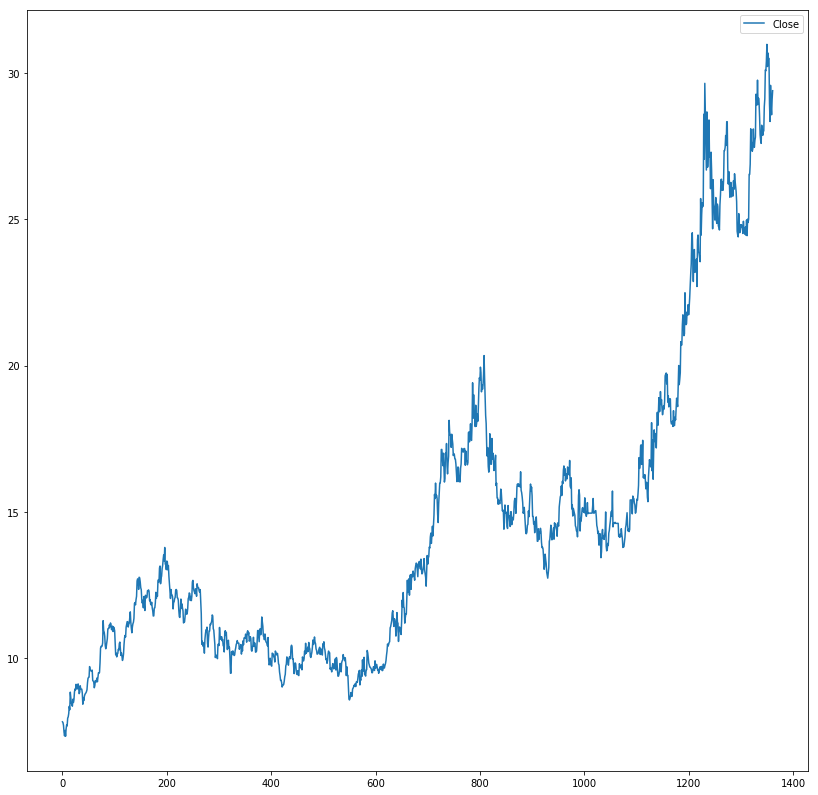

In [106]:
 if DEBUG:
    df_to_plot_dt = converted_df.select('Close').toPandas()
    plt_dt.figure(figsize=(14, 14))
    plt_dt.plot(df_to_plot_dt)
    plt_dt.legend(df_to_plot_dt.columns)
    plt_dt.show()

In [107]:
if CCI_i:
    converted_df = converted_df.filter(converted_df.CCI != "NaN")

converted_df = converted_df.filter(converted_df.Profit != "NaN")

converted_df = converted_df.sort(converted_df.id.asc())

# Manual split for training and validating data
if ManualSplit:
    dfp = converted_df.toPandas()

    dfp = np.array_split(dfp, 10)

    p0 = spark.createDataFrame(data=dfp[0])
    p1 = spark.createDataFrame(data=dfp[1])
    p2 = spark.createDataFrame(data=dfp[2])
    p3 = spark.createDataFrame(data=dfp[3])
    p4 = spark.createDataFrame(data=dfp[4])
    p5 = spark.createDataFrame(data=dfp[5])
    p6 = spark.createDataFrame(data=dfp[6])
    p7 = spark.createDataFrame(data=dfp[7])
    p8 = spark.createDataFrame(data=dfp[8])
    p9 = spark.createDataFrame(data=dfp[9])

    p_final = p0.union(p1).union(p2).union(p3).union(p4).union(p5).union(
        p6).union(p7).union(p8)
    train = p_final
    test = p9
    #     test = p9.head(10)
    #     test = spark.createDataFrame(test)
else:
    train, test = converted_df.randomSplit([0.9, 0.1],seed=RANDOM_SEED)

print("We have %d training examples and %d test examples." % (train.count(),
                                                              test.count()))
test = test.select(
        [col(c).cast('float') for c in test.columns])

train = train.select(
        [col(c).cast('float') for c in train.columns])

test = test.sort(test.id.asc())

train = train.sort(train.id.asc())


train.show()


We have 1201 training examples and 147 test examples.
+-----+-----+------+-----+-----+------+----+----------+----------+-------+----------+
| Open| High|Volume|  Low|Close|Profit|  id|      MACD|       CCI|    OBV|       RSI|
+-----+-----+------+-----+-----+------+----+----------+----------+-------+----------+
|8.337|8.337|   0.0|8.337|8.337|   0.0|13.0|0.07394994| 139.01875| -310.0|     100.0|
|8.223|8.223|   0.0|8.223|8.223|   1.0|14.0|0.08548735|  96.65555| -310.0|  75.89845|
|8.587|8.824| 370.0|8.587|8.824|   0.0|15.0|0.12712103| 148.12761|   60.0|  88.16198|
|8.634|8.634| 350.0|8.616|8.616|   0.0|16.0|0.14504555| 105.22151| -290.0| 65.113754|
|8.402|8.402|   0.0|8.402|8.402|   0.0|18.0|0.14343652|  54.92698|-1540.0|       0.0|
|8.344|8.344|   0.0|8.344|8.344|   1.0|19.0|0.13570516|  39.07378|-1540.0|       0.0|
|8.583|8.583|   0.0|8.583|8.583|   0.0|20.0| 0.1428062|  70.22051|-1540.0|  71.13095|
|8.471|8.471|   0.0|8.471|8.471|   1.0|21.0|0.13945703|  43.57233|-1540.0| 58.435093|


In [108]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer

featuresCols = converted_df.columns
featuresCols.remove('Profit')
featuresCols.remove('id')

print(featuresCols)

# Vector Assembler
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
# Used for assembling features into a vector.
# We will pass all the columns that we are going to use for the prediction to the VectorAssembler and
# it will create a new vector column.
vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")

# VectorIndexer:
# is used to index categorical predictors in a featuresCol column.
# Remember that featuresCol is a single column consisting of vectors (refer to featuresCol and labelCol).
# Each row is a vector which contains values from each predictors.

featureIndexer_rt = VectorIndexer(
    inputCol="rawFeatures",
    outputCol="features",
    maxCategories=len(featuresCols))

['Open', 'High', 'Volume', 'Low', 'Close', 'MACD', 'CCI', 'OBV', 'RSI']


In [109]:
if RT:
    # Algorithm
    from pyspark.ml.classification import RandomForestClassifier

    rt = RandomForestClassifier(labelCol='Profit', featuresCol="features")

    # Define a grid of hyperparameters to test:
    #  - maxDepth: max depth of each decision tree in the ensemble
    # In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher)
    # and more trees in the ensemble (>100).

    max_Depth_Range = list(range(10, 20))
    maxTrees = list(range(50, 100))

    paramGrid_rt = ParamGridBuilder() \
        .addGrid(rt.maxDepth, max_Depth_Range) \
        .addGrid(rt.numTrees, maxTrees) \
        .addGrid(rt.maxMemoryInMB, [1500] ).build()

    # We define an evaluation metric. This tells CrossValidator how well we are doing by comparing the true
    # labels with predictions.

    evaluator_rt = BinaryClassificationEvaluator(
        labelCol=rt.getLabelCol(),
        metricName='areaUnderROC',
        rawPredictionCol=rt.getRawPredictionCol())

    evaluator_rt_PR = BinaryClassificationEvaluator(
        labelCol=rt.getLabelCol(),
        metricName='areaUnderPR',
        rawPredictionCol=rt.getRawPredictionCol())

    # Declare the CrossValidator, which runs model tuning for us.
    cv_rt = CrossValidator(
        estimator=rt,
        evaluator=evaluator_rt,
        estimatorParamMaps=paramGrid_rt,
        numFolds=10)

In [110]:
if DT:
    # Algorithm
    from pyspark.ml.classification import DecisionTreeClassifier
    
    rt = DecisionTreeClassifier(labelCol='Profit', featuresCol="features")

    # Define a grid of hyperparameters to test:
    #  - maxDepth: max depth of each decision tree in the ensemble
    # In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher)
    # and more trees in the ensemble (>100).

    max_Depth_Range = list(range(12, 20))
    min_InstancesPerNode = list(range(1, 5))

    paramGrid_rt = ParamGridBuilder() \
        .addGrid(rt.maxDepth, max_Depth_Range) \
        .addGrid(rt.maxBins, max_bins) \
        .addGrid(rt.minInstancesPerNode, min_InstancesPerNode) \
        .addGrid(rt.maxMemoryInMB, [1500] ).build()

    # We define an evaluation metric. This tells CrossValidator how well we are doing by comparing the true
    # labels with predictions.

    evaluator_rt = BinaryClassificationEvaluator(
        labelCol=rt.getLabelCol(),
        metricName='areaUnderROC',
        rawPredictionCol=rt.getRawPredictionCol())

    evaluator_rt_PR = BinaryClassificationEvaluator(
        labelCol=rt.getLabelCol(),
        metricName='areaUnderPR',
        rawPredictionCol=rt.getRawPredictionCol())

    # Declare the CrossValidator, which runs model tuning for us.
    cv_rt = CrossValidator(
        estimator=rt,
        evaluator=evaluator_rt,
        estimatorParamMaps=paramGrid_rt,
        numFolds=10)

In [111]:
if GBT:
    # Algorithm
    from pyspark.ml.classification import GBTClassifier
    
    rt = GBTClassifier(maxIter=5, labelCol='Profit', featuresCol="features")

    # Define a grid of hyperparameters to test:
    #  - maxDepth: max depth of each decision tree in the ensemble
    # In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher)
    # and more trees in the ensemble (>100).

    max_Depth_Range = list(range(8, 9))
    min_InstancesPerNode = list(range(1, 5))
    
    paramGrid_rt = ParamGridBuilder() \
        .addGrid(rt.maxDepth, max_Depth_Range) \
        .addGrid(rt.maxMemoryInMB, [1000] ).build()

    # We define an evaluation metric. This tells CrossValidator how well we are doing by comparing the true
    # labels with predictions.

    evaluator_rt = BinaryClassificationEvaluator(
        labelCol=rt.getLabelCol(),
        metricName='areaUnderROC',
        rawPredictionCol=rt.getPredictionCol())

    evaluator_rt_PR = BinaryClassificationEvaluator(
        labelCol=rt.getLabelCol(),
        metricName='areaUnderPR',
        rawPredictionCol=rt.getPredictionCol())

    # Declare the CrossValidator, which runs model tuning for us.
    cv_rt = CrossValidator(
        estimator=rt,
        evaluator=evaluator_rt,
        estimatorParamMaps=paramGrid_rt,
        numFolds=3)

In [112]:
from pyspark.ml.classification import GBTClassificationModel

GBTClassificationModel.getMaxDepth = (
    lambda self: self._java_obj.getMaxDepth())


GBTClassificationModel.getMinInstancesPerNode = (
    lambda self: self._java_obj.getMinInstancesPerNode())

In [113]:
# if DEBUG:
#     train.repartition(1).write.csv("PreProcessedSets/TrainSet_" + str(time.mktime(datetime.datetime.today().timetuple())) + "_.csv", header = 'True')
#     test.repartition(1).write.csv("PreProcessedSets/TestSet_" + str(time.mktime(datetime.datetime.today().timetuple())) + "_.csv", header = 'True')

In [114]:
# Creating Final pipeline object
pipeline_rt = Pipeline(stages=[vectorAssembler_rt, featureIndexer_rt, cv_rt])

# FITTING!
pipelineModel_rt = pipeline_rt.fit(train)

# Getting the Best Model
best_classifier = pipelineModel_rt.stages[-1].bestModel

In [115]:
# Feature importance
print('Features importances' + str(best_classifier.featureImportances))

# Max depth
print("Maximal depth is " + str(best_classifier.getMaxDepth()))
max_depth = best_classifier.getMaxDepth()

# Best number of Trees
print("Best number of trees is " + str(best_classifier.getNumTrees))

# Min instances
print("Minimal instances per node is " + str(best_classifier.getMinInstancesPerNode()))
min_instancesPerNode = best_classifier.getMinInstancesPerNode()

# Making Predictions!
predictions_rt = pipelineModel_rt.transform(test)

# Calculating metrics
AreaUnderROC = evaluator_rt.evaluate(predictions_rt)
print("AreaUnderROC on our test set: %g" % AreaUnderROC)

# Calculating metrics
AreaUnderPR = evaluator_rt_PR.evaluate(predictions_rt)
print("AreaUnderPR on our test set: %g" % AreaUnderPR)

#evaluate results
testCount = predictions_rt.count()

FP = predictions_rt.where("prediction = 0 AND Profit=1").count() #FN
FN = predictions_rt.where("prediction = 1 AND Profit=0").count() #TN
TP = predictions_rt.where("prediction = 1 AND Profit=1").count() #TP
TN = predictions_rt.where("prediction = 0 AND Profit=0").count() #TN

print("Test count | FN | TN | TP | TN")
print(str(testCount)+" | "+str(FP)+" | "+str(FN)+" | "+str(TP)+" | "+str(TN)) 



Features importances(9,[0,1,2,3,4,5,6,7,8],[0.0963329229604,0.0623729757266,0.0819147600051,0.0260007790867,0.0289039890728,0.211056392211,0.235000210845,0.107005691158,0.151412278934])
Maximal depth is 8
Best number of trees is 5
Minimal instances per node is 1
AreaUnderROC on our test set: 0.495455
AreaUnderPR on our test set: 0.645331
Test count | FN | TN | TP | TN
147 | 37 | 37 | 40 | 33


In [116]:
# final_model = pipelineModel_rt
from random import *

for i in range(10):
    new_train, new_test = converted_df.randomSplit([0.9, 0.1], seed=i+1)
    new_test = new_test.sort(new_test.id.asc())
    
    predictions = pipelineModel_rt.transform(new_test)
    
    # Calculating metrics
    AreaUnderROC = evaluator_rt.evaluate(predictions)
    print("AreaUnderROC on our test set: %g" % AreaUnderROC)

    # Calculating metrics
    AreaUnderPR = evaluator_rt_PR.evaluate(predictions)
    print("AreaUnderPR on our test set: %g" % AreaUnderPR)

    #evaluate results
    testCount = predictions_rt.count()

    FP = predictions_rt.where("prediction = 0 AND Profit=1").count() #FN
    FN = predictions_rt.where("prediction = 1 AND Profit=0").count() #TN
    TP = predictions_rt.where("prediction = 1 AND Profit=1").count() #TP
    TN = predictions_rt.where("prediction = 0 AND Profit=0").count() #TN

    print("Test count | FN | TN | TP | TN")
    print(str(testCount)+" | "+str(FP)+" | "+str(FN)+" | "+str(TP)+" | "+str(TN))
    
    print("####################################################\n\n")
    
    

AreaUnderROC on our test set: 0.830168
AreaUnderPR on our test set: 0.868475
Test count | FN | TN | TP | TN
147 | 37 | 37 | 40 | 33
####################################################


AreaUnderROC on our test set: 0.739627
AreaUnderPR on our test set: 0.81241
Test count | FN | TN | TP | TN
147 | 37 | 37 | 40 | 33
####################################################


AreaUnderROC on our test set: 0.793294
AreaUnderPR on our test set: 0.826532
Test count | FN | TN | TP | TN
147 | 37 | 37 | 40 | 33
####################################################


AreaUnderROC on our test set: 0.825163
AreaUnderPR on our test set: 0.833787
Test count | FN | TN | TP | TN
147 | 37 | 37 | 40 | 33
####################################################


AreaUnderROC on our test set: 0.771419
AreaUnderPR on our test set: 0.803133
Test count | FN | TN | TP | TN
147 | 37 | 37 | 40 | 33
####################################################


AreaUnderROC on our test set: 0.744691
AreaUnderPR on our test set

Py4JJavaError: An error occurred while calling o5686.csv.
: java.lang.UnsupportedOperationException: CSV data source does not support struct<type:tinyint,size:int,indices:array<int>,values:array<double>> data type.
	at org.apache.spark.sql.execution.datasources.csv.CSVUtils$.org$apache$spark$sql$execution$datasources$csv$CSVUtils$$verifyType$1(CSVUtils.scala:127)
	at org.apache.spark.sql.execution.datasources.csv.CSVUtils$$anonfun$verifySchema$1.apply(CSVUtils.scala:131)
	at org.apache.spark.sql.execution.datasources.csv.CSVUtils$$anonfun$verifySchema$1.apply(CSVUtils.scala:131)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at scala.collection.IterableLike$class.foreach(IterableLike.scala:72)
	at org.apache.spark.sql.types.StructType.foreach(StructType.scala:98)
	at org.apache.spark.sql.execution.datasources.csv.CSVUtils$.verifySchema(CSVUtils.scala:131)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.prepareWrite(CSVFileFormat.scala:65)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:142)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:145)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:58)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:56)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:74)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:117)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:117)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:138)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:135)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:116)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:92)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:92)
	at org.apache.spark.sql.execution.datasources.DataSource.writeInFileFormat(DataSource.scala:438)
	at org.apache.spark.sql.execution.datasources.DataSource.write(DataSource.scala:474)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:58)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:56)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:74)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:117)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:117)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:138)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:135)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:116)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:92)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:92)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:610)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:233)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:217)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:598)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [120]:
predictions.repartition(1).select("id", "Prediction").write.csv("./GBT_Final.csv", header = 'True')

# test = predictions_rt.toPandas()
# csv_buffer = StringIO()
# test.to_csv(csv_buffer)

# s3_resource = boto3.resource('s3')

# s3_resource.Object('logs102', 'RT_Final.csv').put(Body=csv_buffer.getvalue())

# if DEBUG != True:
#     df_to_plot_rt = predictions_rt.select('prediction', 'Profit')
#     print(df_to_plot_rt)
#     df_to_plot_rt = df_to_plot_rt.toPandas()
#     plt_dt.figure(figsize=(14, 14))
#     plt_dt.plot(df_to_plot_rt)
#     plt_dt.legend(df_to_plot_rt.columns)
#     plt_dt.show()
